# Emission line analysis

In this tutorial we will analyze the Pa$\beta$ emission line in the $J$ band spectrum of GQ Lup B. This hydrogen emission line is related to the accretion processes in the circumsubstellar disk around this young, directly imaged brown dwarf.

## Getting started

We start by importing the required Python modules.

In [1]:
import urllib.request
import species
from IPython.display import Image

Next, we initiate the *species* workflow by running the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html?highlight=speciesinit#species.core.setup.SpeciesInit) class.

In [2]:
species.SpeciesInit()

Initiating species v0.4.0... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


We will also download the VLT/SINFONI $J$ band spectrum of GQ Lup B that has been published by [Seifahrt et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..309S/abstract).

In [3]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/gqlupb_sinfoni_j.dat',
                           'gqlupb_sinfoni_j.dat')

('gqlupb_sinfoni_j.dat', <http.client.HTTPMessage at 0x14aca88b0>)

## Adding data of GQ Lup B to the database

To add data to the HDF5 database, we first create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html?highlight=database#species.data.database.Database). This object provides read and write access to the HDF5 file.

In [4]:
database = species.Database()

Next, we will add the available [magnitudes and distance](https://github.com/tomasstolker/species/blob/master/species/data/companions.py) of GQ Lup B to the database (only the distance is required later on for calculating the line luminosity) by using the [add_companion](https://species.readthedocs.io/en/latest/species.data.html?highlight=database#species.data.database.Database.add_companion) method of `Database`. This method will add the magnitudes and filter profiles, but it also downloads a flux-calibrated spectrum of Vega and converts the magnitudes into fluxes.

In [5]:
database.add_companion('GQ Lup B')

Adding Vega spectrum... [DONE]
Adding filter: HST/WFPC2-PC.F606W... [DONE]
Adding filter: HST/WFPC2-PC.F814W... [DONE]
Adding filter: HST/NICMOS2.F171M... [DONE]
Adding filter: HST/NICMOS2.F190N... [DONE]
Adding filter: HST/NICMOS2.F215N... [DONE]
Adding filter: Magellan/VisAO.ip... [DONE]
Adding filter: Magellan/VisAO.zp... [DONE]
Adding filter: Magellan/VisAO.Ys... [DONE]
Adding filter: MKO/NSFCam.H... [DONE]
Adding filter: Paranal/NACO.NB405... [DONE]
Adding filter: Paranal/NACO.Mp... [DONE]
Adding filter: Paranal/NACO.Ks... [DONE]
Adding filter: Subaru/CIAO.CH4s... [DONE]
Adding filter: Subaru/CIAO.K... [DONE]
Adding filter: Subaru/CIAO.Lp... [DONE]
Adding object: GQ Lup B
   - Distance (pc) = 154.10 +/- 0.69
   - HST/WFPC2-PC.F606W:
      - Apparent magnitude = 19.19 +/- 0.07
      - Flux (W m-2 um-1) = 5.94e-16 +/- 3.83e-17
   - HST/WFPC2-PC.F814W:
      - Apparent magnitude = 17.67 +/- 0.05
      - Flux (W m-2 um-1) = 1.02e-15 +/- 4.68e-17
   - HST/NICMOS2.F171M:
      - Apparen

Now that the photometric data of GQ Lup B are stored in the database, we will add the $J$ band spectrum by using the [add_object](https://species.readthedocs.io/en/latest/species.data.html?highlight=database#species.data.database.Database.add_object) method. Here, it is important that we use the same argument for `object_name` as was used as `name` with `add_companion` (i.e. *GQ Lup B*). The argument of `spectrum` contains a dictionary with the spectra. Each value is a tuple with the spectrum, covariance matrix (set to `None` in this case), and the spectral resolution.

In [6]:
database.add_object('GQ Lup B',
                    app_mag=None,
                    flux_density=None,
                    spectrum={'SINFONI': ('gqlupb_sinfoni_j.dat', None, 2500.)},
                    deredden=None)

Adding object: GQ Lup B
   - Spectrum:
      - Database tag: SINFONI
      - Filename: gqlupb_sinfoni_j.dat
      - Data shape: (1014, 3)
      - Wavelength range (um): 1.20 - 1.35
      - Mean flux (W m-2 um-1): 3.27e-15
      - Mean error (W m-2 um-1): 2.79e-17
   - Spectral resolution:
      - SINFONI: 2500.0


## Initiating the line analysis

We will now analyze the emission line by first creating an instance of [EmissionLine](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.emission_line.EmissionLine). The spectrum is read from the database by providing the same object name and spectrum name as were used with `add_object`. We will select a limited wavelength range around the Pa$\beta$ line by setting the argument of `wavel_range`.

In [7]:
line = species.EmissionLine(object_name='GQ Lup B',
                            spec_name='SINFONI',
                            lambda_rest=1.282,
                            wavel_range=(1.26, 1.32))

Let's have a look at the data of the cropped $J$ spectrum that is extracted.

In [8]:
line.spectrum

array([[1.26000500e+00, 3.28487860e-15, 1.58013906e-17],
       [1.26014996e+00, 3.30313622e-15, 1.06466256e-17],
       [1.26029503e+00, 3.32310600e-15, 1.08635306e-17],
       ...,
       [1.31959999e+00, 3.36931744e-15, 8.78280340e-18],
       [1.31974494e+00, 3.40047958e-15, 6.23790556e-17],
       [1.31989002e+00, 3.39223842e-15, 3.46253392e-17]])

## Subtracting the continuum flux

In the $J$ band, we need to subtract the pseudo-continuum of the atmospheric emission. To do so, we make use of the [subtract_continuum](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.emission_line.EmissionLine.subtract_continuum) method of `EmissionLine`. The continuum is modeled with a 3rd order polynomial (after smoothing the spectrum) and we use a linear least square fitting algorithm to optimize the parameters. A plot is created with the result which can be inspected before continuing with the further analysis.

In [9]:
line.subtract_continuum(poly_degree=3,
                        plot_filename='continuum.png')

Fitting continuum... [DONE]
Plotting continuum fit: continuum.png... [DONE]


Let's have a look at the best-fit polynomial model and the continuum-subtracted spectrum.

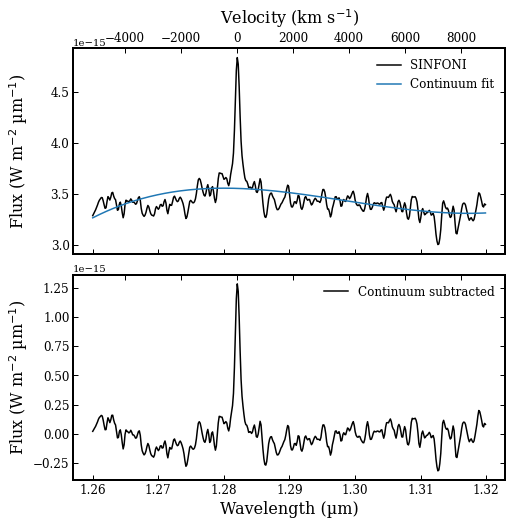

In [10]:
Image('continuum.png')

## Integrating the line flux

Now that the continuum is subtracted, we can determine the line characteristics in two different ways. Here, we will measure the line properties directly from the spectrum. Later on, we will fit a Gaussian profile and adopt the sampled parameters for inferring the line properties.

We use the [integrate_flux](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.emission_line.EmissionLine.integrate_flux) method to integrate the line flux across the specified wavelength range of ``wavel_int`` after interpolating the spectrum to $R = 100000$. Several other characteristics are also calculated from the spectral line. The uncertainties are estimated by sampling 1000 random spectra from the errors on the fluxes.

In [10]:
line.integrate_flux(wavel_int=(1.280, 1.285),
                    interp_kind='linear',
                    plot_filename='line_flux.png')

Plotting integrated line: line_flux.png... [DONE]
Mean wavelength (nm): 1282.09 +/- 0.02
FWHM (km s-1): 202.82 +/- 8.47
Radial velocity (km s-1): 20.5 +/- 5.8
Line flux (W m-2): 1.43e-18 +/- 2.79e-20
Line luminosity (Lsun): 1.06e-06 +/- 2.07e-08


(1.4349177338040668e-18, 2.7893093792069743e-20)

Let's have a look at the plotted output from ``integrate_flux``.

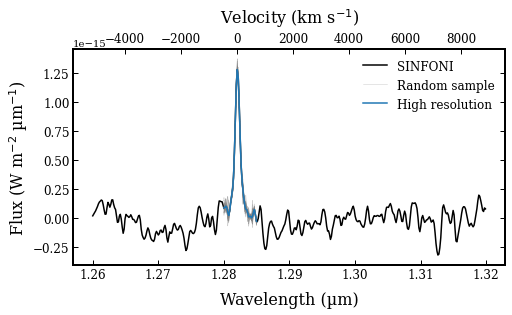

In [12]:
Image('line_flux.png')

## Modeling the Pa$\beta$ emission line

We will now use the [fit_gaussian](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.emission_line.EmissionLine.fit_gaussian) method of `EmissionLine` to fit the spectrum with a Gaussian function while mapping the posterior distributions of the 3 free parameters (amplitude, mean, and standard deviation) with the nested sampling algorithm of [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html). 

The argument of `bounds` is a dictionary with the prior boundaries of the three parameters (`gauss_amplitude`, `gauss_mean`, and `gauss_sigma`). If any parameter is missing or `bounds=None` then conservative boundaries will be estimated from the spectrum. The posterior samples will be stored in the database with the `tag` name and a plot is created with a comparison of the data and best-fit model (i.e. the median parameter values).

In [11]:
line.fit_gaussian(tag='p-beta',
                  min_num_live_points=400,
                  bounds={'gauss_amplitude': (0., 2e-15)},
                  output='ultranest',
                  plot_filename='fit.png',
                  show_status=False)

Creating directory for new run ultranest/run1


/Users/tomasstolker/.pyenv/versions/3.9.6/envs/species3.9/lib/python3.9/site-packages/ultranest/store.py:194: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'points', dtype=np.float,


[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+07  
[ultranest] Likelihood function evaluations: 48776
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -1.325e+07 +- 0.2012
[ultranest] Effective samples strategy satisfied (ESS = 1799.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
Log-evidence = -13250634.57 +/- 0.36
Best-fit parameters (mean +/- std):
   - gauss_amplitude = 1.23e-15 +/- 1.07e-17
   - gauss_mean = 1.28e+00 +/- 5.77e-06
   - gauss_sigma = 4.30e-04 +/- 5.96e-06
Maximum likelihood sample:
   - Log-likelihood = -1.33e+07
   - gauss_amplitude = 1.23e-15
   - gauss_mean = 1.28e+00
   - gauss_sigma = 4.30e-0

Let's have a look at the result!

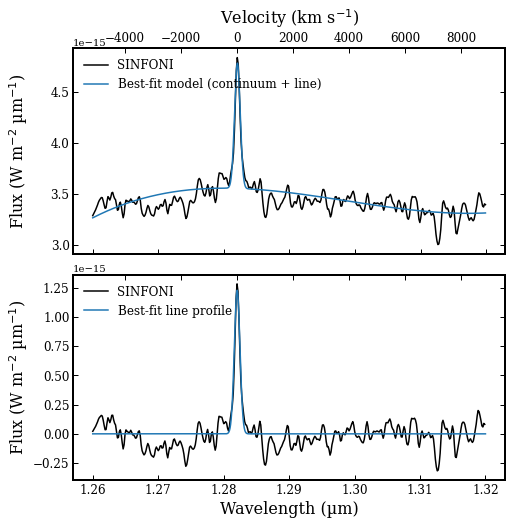

In [14]:
Image('fit.png')

## Plotting the posterior distributions

Now that the posterior samples are available in the database, we can use the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html?highlight=plot_posterior#species.plot.plot_mcmc.plot_posterior) function for visualizing the 1D and 2D projected distributions with [corner.py](https://corner.readthedocs.io). The argument of `tag` is set to the same database tag that was used with `fit_gaussian`.

In [12]:
species.plot_posterior(tag='p-beta',
                       burnin=None,
                       title=None,
                       title_fmt=['.2e', '.3f', '.3f', '.1f', '.2e', '.2e', '.2f', '.0f'],
                       offset=(-0.4, -0.35),
                       output='posterior.png')

Median sample:
   - gauss_amplitude = 1.23e-15
   - gauss_mean = 1.28e+00
   - gauss_sigma = 4.30e-04
   - gauss_fwhm = 2.37e+02
   - line_flux = 1.32e-18
   - line_luminosity = 9.81e-07
   - line_eq_width = -3.72e+00
   - line_vrad = 1.50e+01
   - distance = 1.54e+02
Plotting the posterior: posterior.png... [DONE]


Let's have a look at the result! The first three parameters (from left to right) are the free parameters while the FWHM velocity, line flux, line luminosity, and equivalent width have been calculated from the posterior distributions of these three Gaussian model parameters.

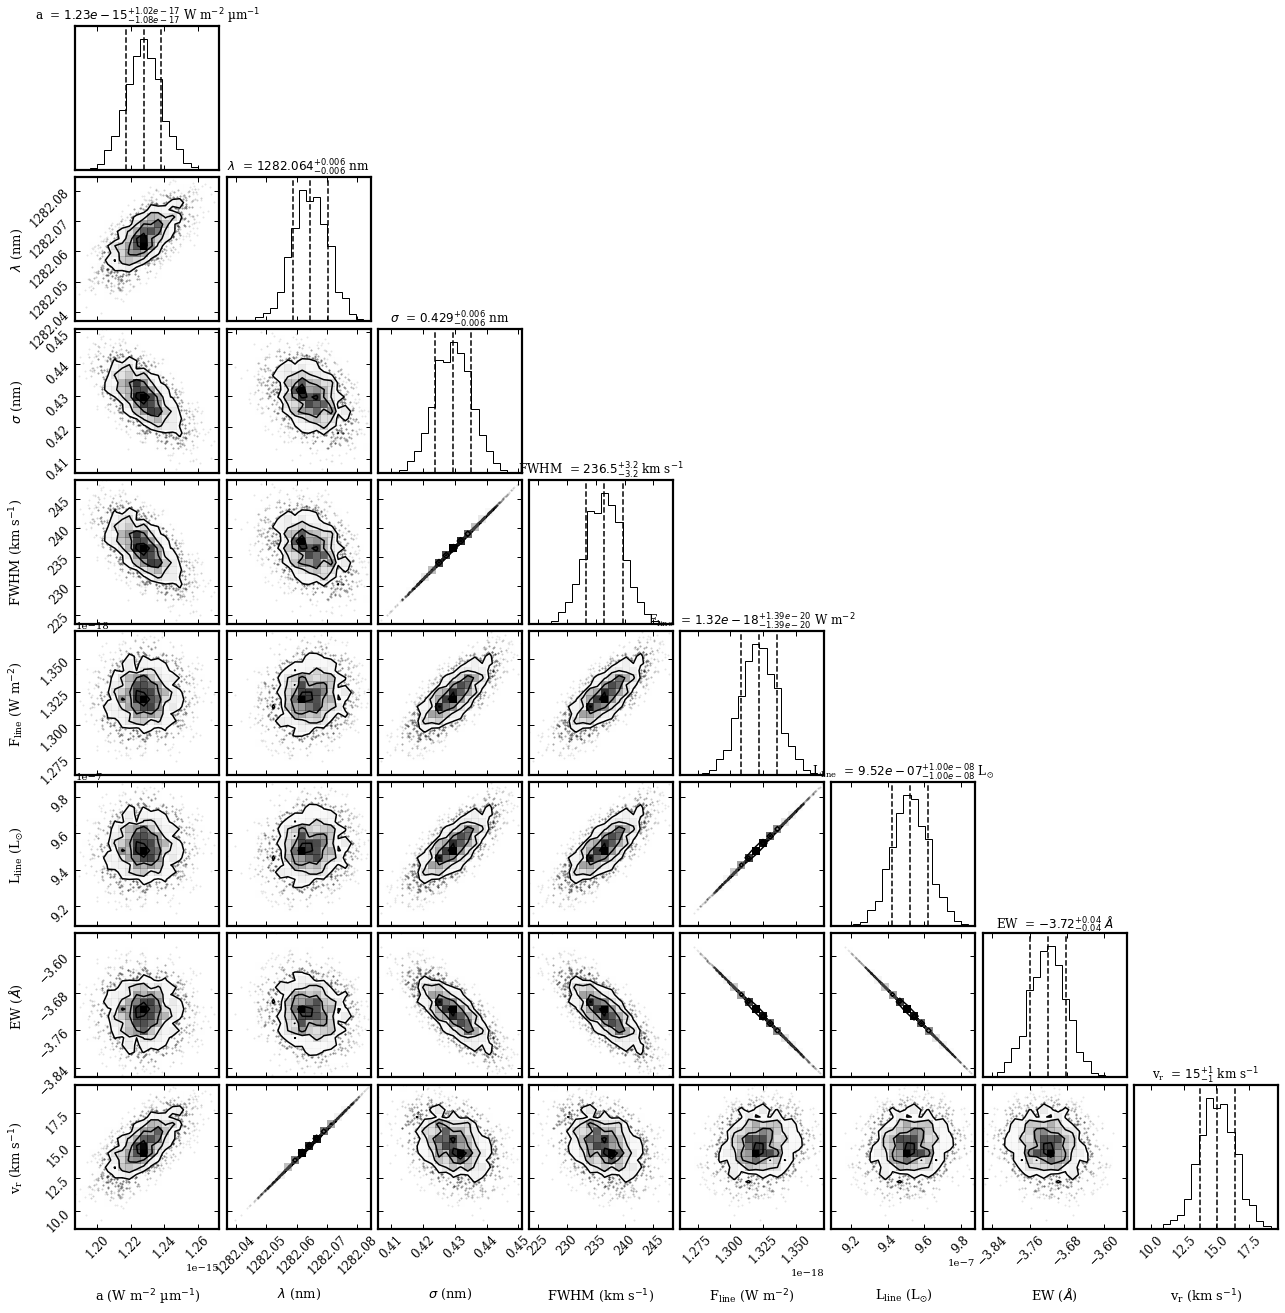

In [16]:
Image('posterior.png')